In [1]:
# train bipedal walker using DDPG
### Credits: github/udacity-deep-reinforcement-learning

In [2]:
import gym
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple, deque
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
env_id = 'BipedalWalker-v3'
env = gym.make(env_id)
env.seed(10)

C:\Users\qasim\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[10]

In [4]:
# switch to GPU if available (Udacity env)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
state_size = env.observation_space.shape[0] #state size = 24

In [6]:
action_size = env.action_space.shape[0] #action size = 4

In [7]:
### Since action space is continuous, we can implement an Actor-Critic method algorithm known as DDPG

### Part 1. Actor Critic

In [8]:
class Actor(nn.Module):
    """
    Actor (policy) model.
    """
    def __init__(self, state_size, action_size, seed, fc_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        return torch.tanh(self.fc2(x))

In [9]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc2.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc3.weight.data.uniform_(-1.5e-3, 1.5e-3)
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

### Part 2. Define Noise model. 
<p>Let's define the noise process model using the standard Ornstein-Uhlenbeck process </p>

In [10]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

### Part 3. Replay Buffer
<p> A DQN operates with a replay buffer that uncorrelates multiple sequences within a trajectory. </p>

In [11]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Part 4. Define main DDPG Agent
<p> Let's tie everything from part 2 and 3 together to build our DDPG agent. </p>

In [12]:
#Define constants:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay

In [13]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed=10):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed. default = 10.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Part 5. Train the agent
<p> Now, we are on our last step, and that is to train the actual agent. </p>

In [14]:
agent = Agent(state_size, action_size) #define agent

In [15]:
scores_global = [] #just in case the kernel gets interrupt before completion

In [16]:
def ddpg(n_episodes=10000, max_t=700):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        scores_global.append(score)#global
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            actor_model_name = 'models/checkpoint_actor' + str("%03d" % (i_episode//100)) + '.pth'
            critic_model_name = 'models/checkpoint_critic' + str("%03d" % (i_episode//100)) + '.pth'
            torch.save(agent.actor_local.state_dict(), actor_model_name)
            torch.save(agent.critic_local.state_dict(), critic_model_name)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
    return scores

In [17]:
scores = ddpg()

Episode 100	Average Score: -106.99	Score: -116.08
Episode 200	Average Score: -118.86	Score: -115.07
Episode 300	Average Score: -110.79	Score: -118.50
Episode 400	Average Score: -99.50	Score: -111.158
Episode 500	Average Score: -112.54	Score: -112.77
Episode 600	Average Score: -103.51	Score: -59.202
Episode 700	Average Score: -87.46	Score: -61.3244
Episode 800	Average Score: -113.57	Score: -121.70
Episode 900	Average Score: -107.26	Score: -117.49
Episode 1000	Average Score: -121.97	Score: -166.50
Episode 1100	Average Score: -95.91	Score: -40.9119
Episode 1200	Average Score: -73.11	Score: -112.15
Episode 1300	Average Score: -104.16	Score: -146.80
Episode 1400	Average Score: -70.60	Score: -24.7686
Episode 1500	Average Score: -45.68	Score: 42.1214
Episode 1600	Average Score: -26.93	Score: -34.189
Episode 1700	Average Score: -62.25	Score: -116.99
Episode 1800	Average Score: -46.24	Score: -131.00
Episode 1900	Average Score: -76.01	Score: -102.01
Episode 2000	Average Score: -98.36	Score: -110

KeyboardInterrupt: 

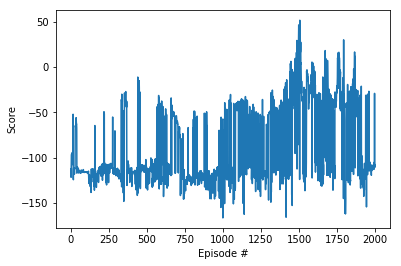

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_global[:2000])+1), scores_global[:2000])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Part 6. Test the agent

In [30]:
agent.actor_local.load_state_dict(torch.load('models/checkpoint_actor016.pth'))
agent.critic_local.load_state_dict(torch.load('models/checkpoint_critic016.pth'))

In [31]:
time.sleep(1) #human is slow.
state = env.reset()
agent.reset()   
total_reward = 0
ep_len = 0
while True:
    action = agent.act(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    total_reward += reward
    if done or ep_len > 1e3:
        print(ep_len)
        break
    ep_len += 1
print(f"Reward:{total_reward}")

1001
Reward:-28.68794959677605


In [ ]:
#END.